# Logistic regression example
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536

---

This notebook demonstrates solving a logistic regression problem of predicting Hypothyrodism with **Scikit-learn** and **Statsmodels** libraries.

The dataset is taken from UCI ML repository.
<br>Here is the link: https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read the dataset

In [2]:
names = 'response age sex on_thyroxine query_on_thyroxine antithyroid_medication thyroid_surgery query_hypothyroid query_hyperthyroid pregnant \
sick tumor lithium goitre TSH_measured TSH T3_measured \
T3 TT4_measured TT4 T4U_measured T4U FTI_measured FTI TBG_measured TBG'

In [3]:
names = names.split(' ')

In [4]:
#!wget https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/master/Datasets/hypothyroid.csv

#!mkdir Data
#!mv hypothyroid.csv Data/

In [5]:
df = pd.read_csv('Data/hypothyroid.csv',index_col=False,names=names,na_values=['?'])

In [6]:
df.head()

,response,age,sex,on_thyroxine,query_on_thyroxine,antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72.0,M,f,f,f,f,f,f,f,...,y,0.6,y,15.0,y,1.48,y,10.0,n,NaN
1,hypothyroid,15.0,F,t,f,f,f,f,f,f,...,y,1.7,y,19.0,y,1.13,y,17.0,n,NaN
2,hypothyroid,24.0,M,f,f,f,f,f,f,f,...,y,0.2,y,4.0,y,1.00,y,0.0,n,NaN
3,hypothyroid,24.0,F,f,f,f,f,f,f,f,...,y,0.4,y,6.0,y,1.04,y,6.0,n,NaN
4,hypothyroid,77.0,M,f,f,f,f,f,f,f,...,y,1.2,y,57.0,y,1.28,y,44.0,n,NaN


In [7]:
to_drop=[]
for c in df.columns:
    if 'measured' in c or 'query' in c:
        to_drop.append(c)

In [8]:
to_drop

['query_on_thyroxine',
 'query_hypothyroid',
 'query_hyperthyroid',
 'TSH_measured',
 'T3_measured',
 'TT4_measured',
 'T4U_measured',
 'FTI_measured',
 'TBG_measured']

In [9]:
to_drop.append('TBG')

In [10]:
df.drop(to_drop,axis=1,inplace=True)

In [11]:
df.head()

,response,age,sex,on_thyroxine,antithyroid_medication,thyroid_surgery,pregnant,sick,tumor,lithium,goitre,TSH,T3,TT4,T4U,FTI
0,hypothyroid,72.0,M,f,f,f,f,f,f,f,f,30.0,0.6,15.0,1.48,10.0
1,hypothyroid,15.0,F,t,f,f,f,f,f,f,f,145.0,1.7,19.0,1.13,17.0
2,hypothyroid,24.0,M,f,f,f,f,f,f,f,f,0.0,0.2,4.0,1.00,0.0
3,hypothyroid,24.0,F,f,f,f,f,f,f,f,f,430.0,0.4,6.0,1.04,6.0
4,hypothyroid,77.0,M,f,f,f,f,f,f,f,f,7.3,1.2,57.0,1.28,44.0


### Let us see the basic statistics on the dataset

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2717.0,51.154214,19.294405,1.0,35.00,54.00,67.000,98.00
TSH,2695.0,5.923180,23.899467,0.0,0.00,0.70,2.300,530.00
T3,2468.0,1.939749,0.996773,0.0,1.40,1.80,2.300,10.20
TT4,2914.0,108.850000,45.485419,2.0,83.00,104.00,128.000,450.00
T4U,2915.0,0.978199,0.226580,0.0,0.85,0.96,1.065,2.21
FTI,2916.0,115.397771,60.239572,0.0,91.00,107.00,129.000,881.00


### Are any data points are missing? We can check it using `df.isna()` method
The `df.isna()` method gives back a full DataFrame with Boolean values - True for data present, False for missing data. We can use `sum()` on that DataFrame to see and calculate the number of missing values per column.

In [13]:
df.isna().sum()

response                    0
age                       446
sex                        73
on_thyroxine                0
antithyroid_medication      0
thyroid_surgery             0
pregnant                    0
sick                        0
tumor                       0
lithium                     0
goitre                      0
TSH                       468
T3                        695
TT4                       249
T4U                       248
FTI                       247
dtype: int64

### We can use `df.dropna()` method to drop those missing rows

In [14]:
df.dropna(inplace=True)

In [15]:
df.shape

(2000, 16)

### Creating a transformation function to convert `+` or `-` responses to 1 and 0

In [16]:
def class_convert(response):
    if response=='hypothyroid':
        return 1
    else:
        return 0

In [17]:
df['response']=df['response'].apply(class_convert)

In [18]:
df.head()

,response,age,sex,on_thyroxine,antithyroid_medication,thyroid_surgery,pregnant,sick,tumor,lithium,goitre,TSH,T3,TT4,T4U,FTI
0,1,72.0,M,f,f,f,f,f,f,f,f,30.0,0.6,15.0,1.48,10.0
1,1,15.0,F,t,f,f,f,f,f,f,f,145.0,1.7,19.0,1.13,17.0
2,1,24.0,M,f,f,f,f,f,f,f,f,0.0,0.2,4.0,1.00,0.0
3,1,24.0,F,f,f,f,f,f,f,f,f,430.0,0.4,6.0,1.04,6.0
4,1,77.0,M,f,f,f,f,f,f,f,f,7.3,1.2,57.0,1.28,44.0


In [19]:
df.columns

Index(['response', 'age', 'sex', 'on_thyroxine', 'antithyroid_medication',
       'thyroid_surgery', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre',
       'TSH', 'T3', 'TT4', 'T4U', 'FTI'],
      dtype='object')

### Exploratory data analysis

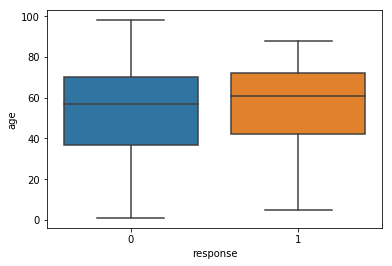

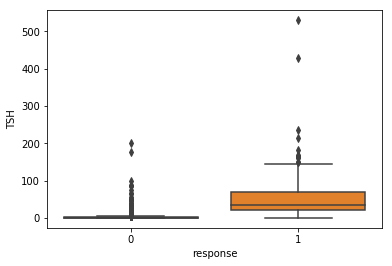

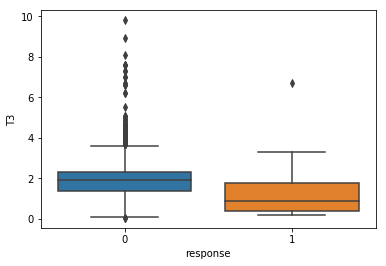

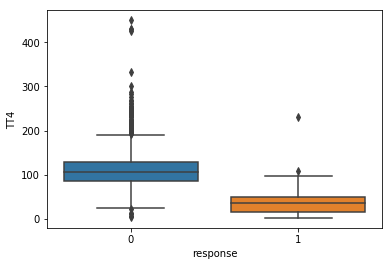

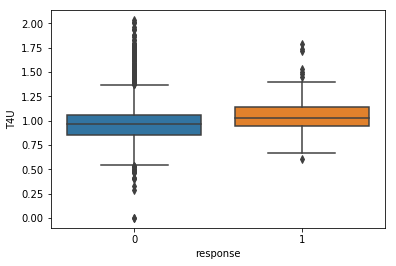

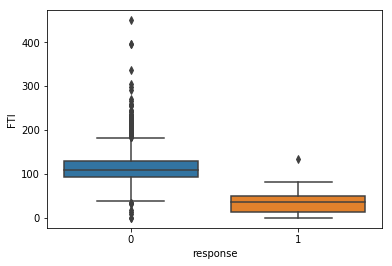

In [20]:
for var in ['age','TSH','T3','TT4','T4U','FTI']:
    sns.boxplot(x='response',y=var,data=df)
    plt.show()

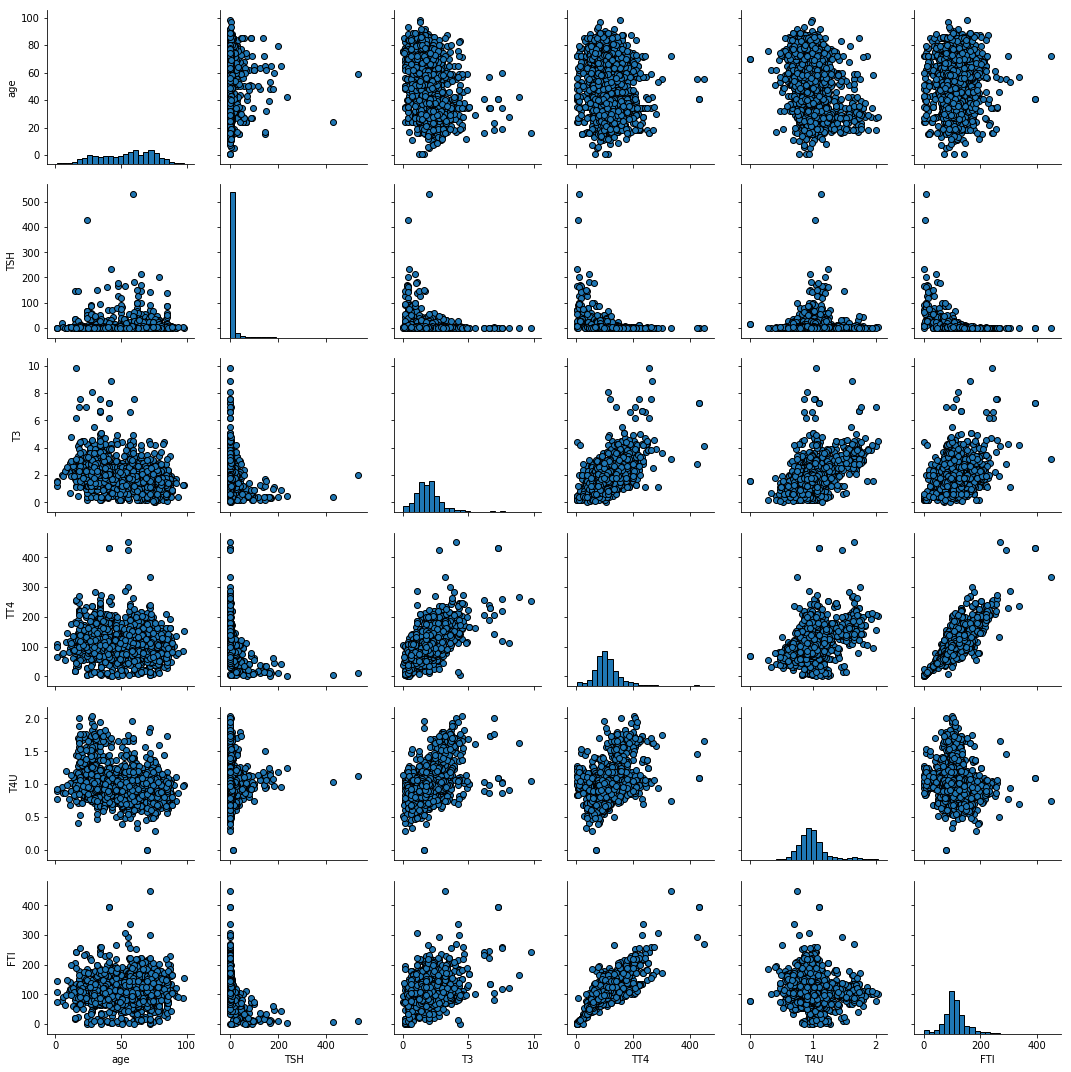

In [21]:
sns.pairplot(data=df[df.columns[1:]],diag_kws={'edgecolor':'k','bins':25},plot_kws={'edgecolor':'k'})
plt.show()

### Create dummy variables for the categorical variables

In [22]:
df_dummies = pd.get_dummies(data=df)

In [23]:
df_dummies.shape

(2000, 25)

In [24]:
df_dummies.sample(10)

,response,age,TSH,T3,TT4,T4U,FTI,sex_F,sex_M,on_thyroxine_f,...,pregnant_f,pregnant_t,sick_f,sick_t,tumor_f,tumor_t,lithium_f,lithium_t,goitre_f,goitre_t
678,0,76.0,0.0,2.6,149.0,1.24,120.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
2803,0,65.0,0.0,0.9,78.0,0.67,116.0,0,1,1,...,1,0,1,0,1,0,1,0,1,0
1404,0,71.0,3.1,1.6,87.0,0.98,89.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
2779,0,63.0,0.4,1.4,115.0,1.02,113.0,0,1,1,...,1,0,1,0,1,0,1,0,1,0
2949,0,70.0,1.6,1.8,175.0,1.18,148.0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
1487,0,60.0,0.9,1.4,138.0,0.92,150.0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
1410,0,32.0,17.4,1.9,90.0,1.21,74.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
1700,0,78.0,6.3,1.1,56.0,0.86,65.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
1131,0,77.0,3.8,0.5,54.0,0.58,93.0,1,0,1,...,1,0,0,1,1,0,1,0,1,0
577,0,28.0,0.8,1.9,85.0,1.06,80.0,1,0,1,...,1,0,1,0,0,1,1,0,1,0


### Test/train split

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop('response',axis=1), 
                                                    df_dummies['response'], test_size=0.30, 
                                                    random_state=42)

In [26]:
print("Training set shape",X_train.shape)
print("Test set shape",X_test.shape)

Training set shape (1400, 24)
Test set shape (600, 24)


### Using `LogisticRegression` estimator from Scikit-learn
We are using the L2 regularization by default

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
clf1 = LogisticRegression(penalty='l2',solver='newton-cg')

In [29]:
clf1.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

### Intercept, coefficients, and score

In [30]:
clf1.intercept_

array([2.28510517])

In [31]:
clf1.coef_

array([[ 0.0203188 ,  0.01861475, -0.32522082,  0.00395531,  0.30700632,
        -0.10796216,  0.30204065, -0.30204118,  0.89772448, -0.89772501,
         0.62687937, -0.6268799 , -0.67443716,  0.67443663,  0.13427707,
        -0.1342776 ,  0.27312666, -0.27312719,  0.26138707, -0.2613876 ,
         0.08932434, -0.08932487, -0.24898789,  0.24898736]])

In [32]:
clf1.score(X_test,y_test)

0.9816666666666667

### For `LogisticRegression` estimator, there is a special `predict_proba` method which computes the raw probability values

In [33]:
prob_threshold = 0.5

In [34]:
prob_df=pd.DataFrame(clf1.predict_proba(X_test[:10]),columns=['Prob of NO','Prob of YES'])
prob_df['Decision']=(prob_df['Prob of YES']>prob_threshold).apply(int)
prob_df

,Prob of NO,Prob of YES,Decision
0,0.990471,0.009529,0
1,0.998714,0.001286,0
2,0.999999,0.000001,0
3,0.624018,0.375982,0
4,0.999296,0.000704,0
5,0.864075,0.135925,0
6,0.983696,0.016304,0
7,0.998507,0.001493,0
8,0.221967,0.778033,1
9,0.999968,0.000032,0


In [35]:
y_test[:10]

2944    0
511     0
2116    0
1412    0
2039    0
2013    0
1478    0
2744    0
83      1
2100    0
Name: response, dtype: int64

### Classification report, and confusion matrix

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
print(classification_report(y_test, clf1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       569
           1       0.86      0.77      0.81        31

   micro avg       0.98      0.98      0.98       600
   macro avg       0.92      0.88      0.90       600
weighted avg       0.98      0.98      0.98       600



In [38]:
pd.DataFrame(confusion_matrix(y_test, clf1.predict(X_test)),columns=['Predict-YES','Predict-NO'],index=['YES','NO'])

,Predict-YES,Predict-NO
YES,565,4
NO,7,24


### Using `statsmodels` library

In [39]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [40]:
df_dummies.columns

Index(['response', 'age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'sex_F', 'sex_M',
       'on_thyroxine_f', 'on_thyroxine_t', 'antithyroid_medication_f',
       'antithyroid_medication_t', 'thyroid_surgery_f', 'thyroid_surgery_t',
       'pregnant_f', 'pregnant_t', 'sick_f', 'sick_t', 'tumor_f', 'tumor_t',
       'lithium_f', 'lithium_t', 'goitre_f', 'goitre_t'],
      dtype='object')

### Create a 'formula' in the same style as in R language

In [41]:
formula = 'response ~ ' + '+'.join(df_dummies.columns[1:])

In [42]:
formula

'response ~ age+TSH+T3+TT4+T4U+FTI+sex_F+sex_M+on_thyroxine_f+on_thyroxine_t+antithyroid_medication_f+antithyroid_medication_t+thyroid_surgery_f+thyroid_surgery_t+pregnant_f+pregnant_t+sick_f+sick_t+tumor_f+tumor_t+lithium_f+lithium_t+goitre_f+goitre_t'

### Fit a GLM (Generalized Linear model) with this formula and choosing `Binomial` as the family of function

In [43]:
model = smf.glm(formula = formula, data=df_dummies, family=sm.families.Binomial())

In [44]:
result=model.fit()

### `summary` method shows a R-style table with all kind of statistical information

In [45]:
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1984
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -123.59
Date:                Wed, 21 Aug 2019   Deviance:                       247.17
Time:                        14:54:43   Pearson chi2:                 9.10e+03
No. Iterations:                    22   Covariance Type:             nonrobust
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.1161   4981.804     -0.001      1.000   -9767.273    9761.041
age       

### The `predict` method computes probability for the test dataset

In [46]:
result.predict(X_test[:10])

2944    2.408353e-03
511     6.250161e-04
2116    6.125699e-07
1412    3.274420e-01
2039    7.888963e-04
2013    1.325293e-01
1478    3.197375e-02
2744    1.098108e-03
83      8.650453e-01
2100    6.524129e-05
dtype: float64

### To create binary predictions, you have to apply a threshold probability and convert the booleans into integers

In [47]:
y_pred=(result.predict(X_test)>prob_threshold).apply(int)

In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       569
           1       0.89      0.77      0.83        31

   micro avg       0.98      0.98      0.98       600
   macro avg       0.94      0.88      0.91       600
weighted avg       0.98      0.98      0.98       600



In [49]:
pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['Predict-YES','Predict-NO'],index=['YES','NO'])

,Predict-YES,Predict-NO
YES,566,3
NO,7,24


### A smaller model with only first few variables

We saw that majority of variables in the logistic regression model has p-values very high and therefore they are not statistically significant. We create another smaller model removing those variables.

In [50]:
formula = 'response ~ ' + '+'.join(df_dummies.columns[1:7])
formula

'response ~ age+TSH+T3+TT4+T4U+FTI'

In [51]:
model = smf.glm(formula = formula, data=df_dummies, family=sm.families.Binomial())
result=model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1993
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -131.55
Date:                Wed, 21 Aug 2019   Deviance:                       263.09
Time:                        14:54:43   Pearson chi2:                 5.65e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1596      1.995      2.085      0.037       0.250       8.069
age            0.0248      0.010      2.481      0.0

In [52]:
y_pred=(result.predict(X_test)>prob_threshold).apply(int)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       573
           1       0.74      0.85      0.79        27

   micro avg       0.98      0.98      0.98       600
   macro avg       0.87      0.92      0.89       600
weighted avg       0.98      0.98      0.98       600



In [53]:
pd.DataFrame(confusion_matrix(y_test, y_pred),columns=['Predict-YES','Predict-NO'],index=['YES','NO'])

,Predict-YES,Predict-NO
YES,565,4
NO,8,23


### How do the probabilities compare between `Scikit-learn` and `Statsmodels` predictions? 

In [54]:
sklearn_prob = clf1.predict_proba(X_test)[...,1][:10]
statsmodels_prob =  result.predict(X_test[:10])

In [55]:
prob_comp_df=pd.DataFrame(data={'Scikit-learn Prob':list(sklearn_prob),'Statsmodels Prob':list(statsmodels_prob)})
prob_comp_df

,Scikit-learn Prob,Statsmodels Prob
0,0.009529,0.026742
1,0.001286,0.000780
2,0.000001,0.000001
3,0.375982,0.306287
4,0.000704,0.000797
5,0.135925,0.132377
6,0.016304,0.007412
7,0.001493,0.001065
8,0.778033,0.874865
9,0.000032,0.000161


### Coefficient interpretation

What is the interpretation of the coefficient value for `age` and `FTI`?

- With every one year of age increase, the log odds of the hypothyrodism **increases** by 0.0248 or the odds of hypothyroidsm increases by a factor of exp(0.0248) = 1.025 i.e. almost 2.5%.
- With every one unit of FTI increase, the log odds of the hypothyrodism **decreases** by 0.1307 or the odds of hypothyroidsm decreases by a factor of exp(0.1307) = 1.1396 i.e. almost by 12.25%.